# Fake maps with fake seeing

+ Generate simulated emissivity and velocity cubes
+ Integrate them to get simulated intensity, velocity (and sigma) maps
+ Calculate structure functions and other statistics (PDFs, delta variance, etc)
+ Apply fake seeing to the cubes and investigate the effect on the structure function, etc
+ Also see if there is any difference if we just simulate a velocity map and apply seeing to that

In [1]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from matplotlib import pyplot as plt
import turbustat.statistics as tss
import turbustat.simulator
from turbustat.simulator import make_3dfield
from turb_utils import make_extended
import seaborn as sns
import sys
sys.path.append("../muse-strucfunc")
import strucfunc

sns.set_color_codes()
sns.set_context("talk")

## Fake velocity maps only

### Compare pure power law with tapered power law

The standard `make_extended()` function from `turbustat` gives a power law field (`vmap0`).  I have modified it to use an exponential taper at large scales, which I use to make `vmap` (all other parameters are the same as `vmap0`).

In [2]:
r0 = 32.0
N = 256
m = 1.2
vmap = make_extended(
    N, powerlaw=2.0 + m, 
    ellip=0.5, theta=45, 
    correlation_length=r0,
    randomseed=2021_10_08,
)
signorm = vmap.std()
vmap /= signorm

vmap0 = make_extended(
    N, powerlaw=2.0 + m, 
    ellip=0.5, theta=45, 
    randomseed=2021_10_08,
)
signorm0 = vmap0.std()
vmap0 /= signorm0
signorm, signorm0

(4.399613458965613, 8.789997112996469)

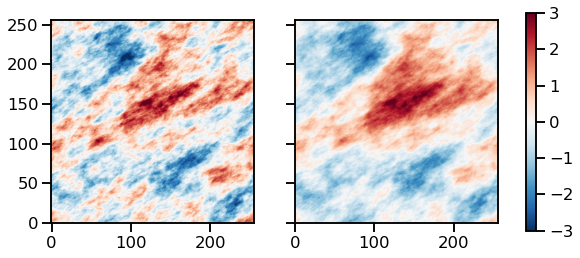

In [3]:
fig, (ax, axx) = plt.subplots(
    1, 2, 
    sharey=True,
    figsize=(10, 4),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
im = ax.imshow(vmap, **imshow_kwds)
im = axx.imshow(vmap0, **imshow_kwds)
fig.colorbar(im, ax=[ax, axx])

The left-hand figure is the tapered map. The right-hand figure is the pure power law map. 

Check out the power spectrum of these maps

In [4]:
fftmap = make_extended(
    N, powerlaw=2.0 + m, 
    ellip=0.5, theta=45, 
    correlation_length=r0,
    randomseed=2021_10_08,
    return_fft=True,
)
fftmap0 = make_extended(
    N, powerlaw=2.0 + m, 
    ellip=0.5, theta=45, 
    randomseed=2021_10_08,
    return_fft=True,
)

pmap = np.real(fftmap * np.conj(fftmap))
pmap0 = np.real(fftmap0 * np.conj(fftmap0))

/tmp/ipykernel_43466/1401938230.py:7: RuntimeWarning: divide by zero encountered in log10
  imm = axx.imshow(np.log10(pmap), **imshow_kwds)
/tmp/ipykernel_43466/1401938230.py:8: RuntimeWarning: invalid value encountered in true_divide
  im = ax.imshow((pmap / pmap0), cmap="gray_r", vmin=0.0, vmax=1.0)


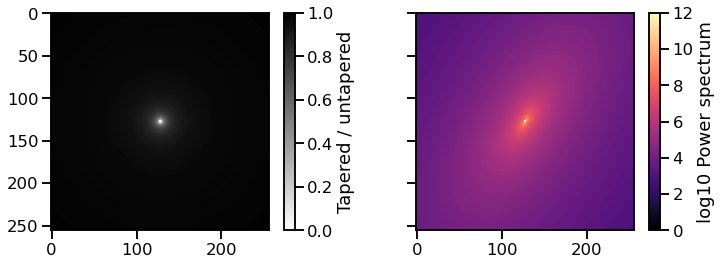

In [5]:
fig, (ax, axx) = plt.subplots(
    1, 2, 
    sharey=True,
    figsize=(12, 4),
)
imshow_kwds = dict(origin="lower", cmap="magma", vmin=0.0, vmax=12.0)
imm = axx.imshow(np.log10(pmap), **imshow_kwds)
im = ax.imshow((pmap / pmap0), cmap="gray_r", vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=ax).set_label("Tapered / untapered")
fig.colorbar(imm, ax=axx).set_label("log10 Power spectrum");

The left-hand image is the ratio of the two power spectra on a linear inverted scale (white = 0, black = 1).  It drops in the middle (low $k$, large scales) as expected.  The right-hand image is the power spectrum itself on a log scale. 

### Structure function of fake velocity map

We compare the structure functions with and without the taper. In both cases, we are using `m = 1.2` and `N = 256`

In [6]:
sf = strucfunc.strucfunc_numba_parallel(vmap, dlogr=0.05)

/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [7]:
sf0 = strucfunc.strucfunc_numba_parallel(vmap0, dlogr=0.05)

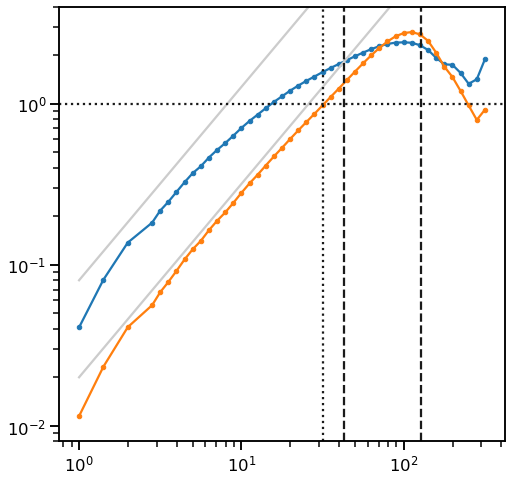

In [8]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sf["N pairs"] > 0
r = 10**sf["log10 r"][mask]
B = sf["Unweighted B(r)"][mask]
B0 = sf0["Unweighted B(r)"][mask]

ax.plot(r, B, marker=".")
ax.plot(r, B0, marker=".")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 4],
);

Note that the untapered version (orange) has a good power law structure function that recovers `m = 1.2` over a wide range of scales.  But the tapered version flattens away from the power law quite quickly. 

Now that we are using a shallower power spectrum, we don't get the correlation length `r0` to come out at exactly the tapering length that we fed in. 

The untapered structure function has a maximum at roughly half the box size and falls for larger scales.  This is likely to be because of the periodic boundary conditions – we will investigate further below. Note that the derived `r0` for the untapered version would be about 1/8 of the box size, but that this is not really a correlation length. 

**So we need a total field of view that is at least 8 times the correlation length in order to be able to recover the latter from the structure function**

### Smoothed version of velocity field



Now we smooth the velocity field directly using a gaussian of different widths.  This is different from what we did with the fake Orion data, where it was the PPV intensity cuve that we smoothed.


In [9]:
from astropy.convolution import Gaussian2DKernel, convolve_fft

In [10]:
widths = [1, 2, 4, 8, 16, 32]
vmaps = {}
for width in widths:
    kernel = Gaussian2DKernel(x_stddev=width)
    vmaps[width] = convolve_fft(vmap, kernel)

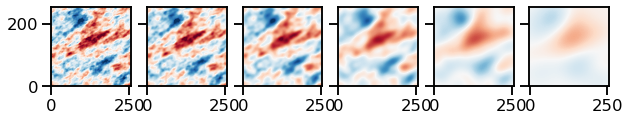

In [11]:
ncols = len(widths)
fig, axgrid = plt.subplots(
    1, ncols, figsize=(10, 5), sharex=True, sharey=True,
)
for ax, width in zip(axgrid, widths):
    im = ax.imshow(
        vmaps[width], 
        origin="lower",
        vmin=-2.5, vmax=2.5,
        cmap="RdBu_r",
    )

These are the maps with the varying degrees of smoothing.  For the greatest degree of smoothing we are starting to reduce the overall amplitude of the fluctuations.

In [12]:
sfs = {}
for width in widths:
    sfs[width] = strucfunc.strucfunc_numba_parallel(
        vmaps[width], dlogr=0.05,
    )

/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


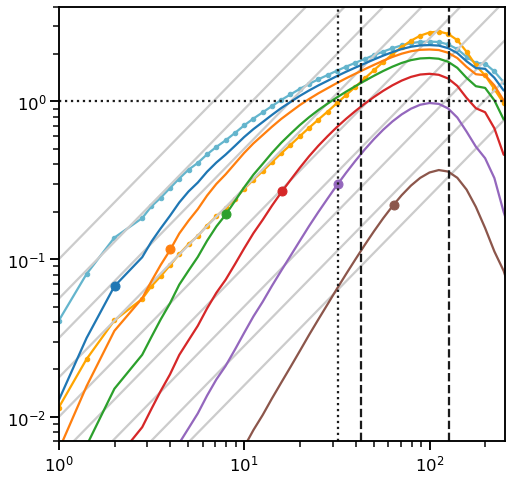

In [13]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sf["N pairs"] > 0
r = 10**sf["log10 r"][mask]
B = sf["Unweighted B(r)"][mask]
B0 = sf0["Unweighted B(r)"][mask]

ax.plot(r, B, marker=".", color="c")
ax.plot(r, B0, marker=".", color="orange")

rgrid = np.logspace(-1.0, 2.5)
for a in np.logspace(-3, -1, 9):
    ax.plot(rgrid, a * rgrid**m, color="0.8")

for width in widths:
    r = 10**sfs[width]["log10 r"][mask]
    B = sfs[width]["Unweighted B(r)"][mask]
    line = ax.plot(r, B)
    B0 = np.interp(2*width, r, B)
    c = line[0].get_color()
    ax.plot(2*width, B0, marker="o", color=c)



ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log", 
    xlim=[1.0, N], ylim=[7e-3, 4.0]);

These are the structure functions after smoothing. The big circle symbols show `2 * s0`. The power law becomes steeper for up to about `4 * s0`.

### Ratio of smoothed to unsmoothed

I copy the functions from the Orion notebook.

In [14]:
def ratio_empirical(rad, s0, a=1.0):
    """
    Simple tanh law in semi-log space to fit the seeing
    
    Reduction in B(r) is always 0.5 when r = 2 * s0
    Parameter `a` controls the slope of the transition.
    """
    x = np.log(rad / (2 * s0))
    y = np.tanh(a * x)
    return 0.5 * (1.0 + y)

def bfac(x):
    """
    Across-the board reduction in B(r) for x = s0 / r0
    
    Where s0 is RMS seeing width and r0 is correlation length
    """
    return 1 / (1 + 4*x**2)

def seeing_empirical(r, s0, r0, a=0.75):
    return bfac(s0 / r0) * ratio_empirical(r, s0, a)

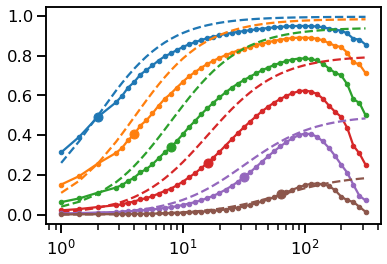

In [15]:
fig, ax = plt.subplots()
B0 = sf["Unweighted B(r)"][mask]
for width in widths:
    r = 10**sfs[width]["log10 r"][mask]
    B = sfs[width]["Unweighted B(r)"][mask]
    rat = B / B0
    line = ax.plot(r, rat, marker=".",)
    rat0 = np.interp(2*width, r, rat)
    c = line[0].get_color()
    ax.plot(2*width, rat0, marker="o", color=c)
    # Functional fit
    ax.plot(r, seeing_empirical(r, width, r0, 0.75), color=c, linestyle="dashed")
ax.set(xscale="log", yscale="linear");

This is the ratio of each smoothed structure function to the original structure function. The curves look remarlably similar to what we obtained for Orion, despite the very different methodology used here.

The main difference is that the curves drop at the largest scales.  This must be another consequence of the periodic boundary conditions: for the largest scales, we go all the way round and get close again. 

The dashed lines are the model fit that worked for Orion.  These fit OK, but not great. 

### Non-periodic boundaries

We can make a map that is twice as big and then analyze 1/4 of it. That way, it will not be periodic.  First we do the pure power law.

In [16]:
vmap2x2 = make_extended(
    2 * N, powerlaw=2.0 + m, 
    ellip=0.5, theta=45, 
    randomseed=2021_10_08,
)


def split_square_in_4(arr):
    ny, nx = arr.shape
    assert nx == ny and nx % 2 == 0
    slices = slice(None, nx // 2), slice(nx // 2, None)
    corners = []
    for i, j in [
        (0, 0), (0, 1), (1, 0), (1, 1),
    ]:
        corners.append(arr[slices[i], slices[j]])
    return corners

def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

vms = split_square_in_4(vmap2x2)
vms = [normalize(_) for _ in vms]

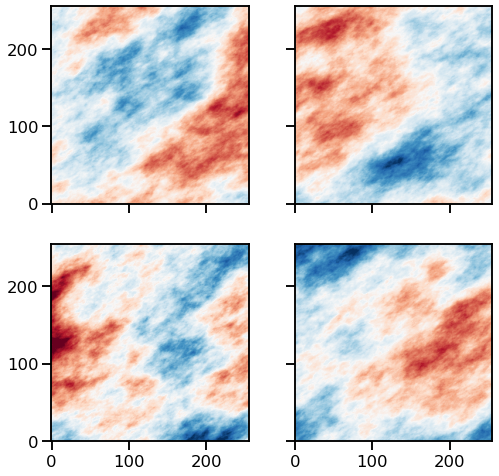

In [17]:
fig, axes = plt.subplots(
    2, 2, 
    sharex=True, sharey=True,
    figsize=(8, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
for vm, ax in zip(vms, axes.flat):
    im = ax.imshow(vm, **imshow_kwds)

In [18]:
sfs_np = [
    strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
    for vm in vms
]

/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


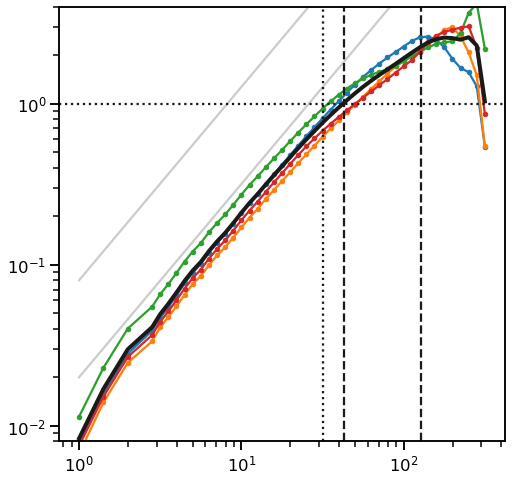

In [19]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_np]
Bm = np.mean(np.stack(Bs), axis=0)

for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 4],
);

This time, the apparent correlation length is 1/6 of the map size, albeit with some variation between the 4 quadrants. This is a bit larger than the 1/8 that we found for the periodic case. 

Now we look at the tapered power law.

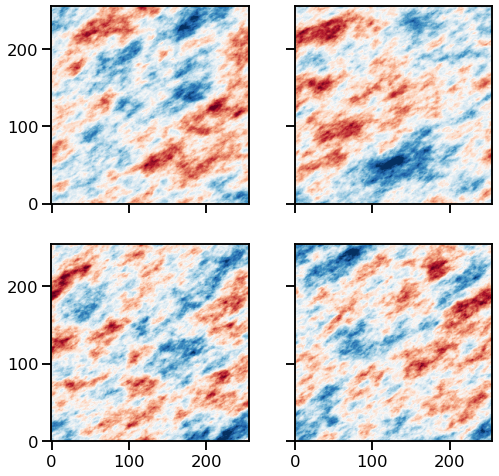

In [20]:
vms_t = split_square_in_4(
    make_extended(
        2 * N, powerlaw=2.0 + m, 
        ellip=0.5, theta=45, 
        correlation_length=r0,
        randomseed=2021_10_08,
    )
)
vms_t = [normalize(_) for _ in vms_t]

fig, axes = plt.subplots(
    2, 2, 
    sharex=True, sharey=True,
    figsize=(8, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
for vm, ax in zip(vms_t, axes.flat):
    im = ax.imshow(vm, **imshow_kwds)

In [21]:
sfs_npt = [
    strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
    for vm in vms_t
]

/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
/Users/will/Dropbox/mariano-velocity-statistics/../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


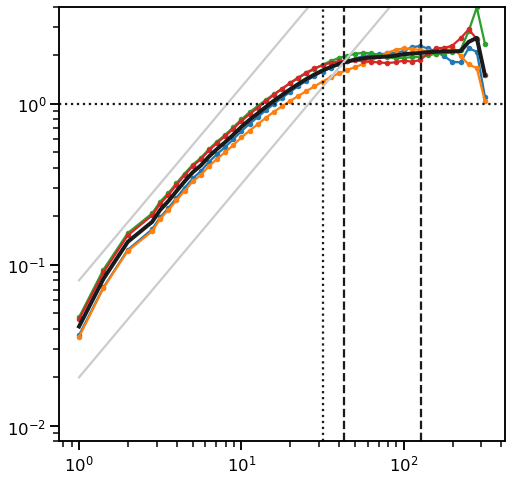

In [22]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_npt]
Bm = np.mean(np.stack(Bs), axis=0)

for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 4],
);

#### Effects of smoothing the non-periodic maps

In [23]:
vmap2x2_t = make_extended(
        2 * N, powerlaw=2.0 + m, 
        ellip=0.5, theta=45, 
        correlation_length=r0,
        randomseed=2021_10_08,
    )
widths = [1, 2, 4, 8, 16, 32]
vmap_nps = {}
for width in widths:
    kernel = Gaussian2DKernel(x_stddev=width)
    vmap_nps[width] = [convolve_fft(normalize(_), kernel) 
                       for _ in split_square_in_4(vmap2x2_t)] 

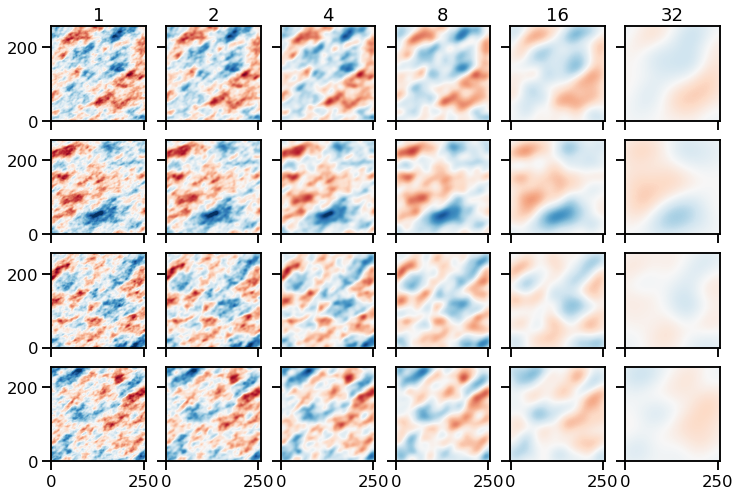

In [24]:
ncols = len(widths)
nrows = 4
fig, axes = plt.subplots(
    nrows, ncols, figsize=(12, 8), sharex=True, sharey=True,
)
for i, width in enumerate(widths):
    for j, vm in enumerate(vmap_nps[width]):
        im = axes[j, i].imshow(vm, **imshow_kwds)
    axes[0, i].set_title(str(width))

In [50]:
def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

In [51]:
try: 
    sfs_npt_s = {
        width: [
            values2arrays(json.load(open(fn))) for fn in Path(".").glob(
                f"fake-tapered-nonp-s0-{width:03d}-*-strucfunc.json"
            )
        ]
        for width in widths
    }
except Exception as e:
    sfs_npt_s = {
        width: [
            strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
            for vm in vmap_nps[width]
        ]
        for width in widths
    }
    for width in widths:
        for jj, (_sf, _vm) in enumerate(zip(sfs_npt_s[width], vmap_nps[width])):
            jsonfilename = f"fake-tapered-nonp-s0-{width:03d}-{jj:02d}-strucfunc.json"
            sig2 = _sf["Unweighted sigma^2"] = np.var(_vm)
            B = _sf["Unweighted B(r)"][mask]
            true_r0 = _sf["Apparent r0"] = np.interp(sig2, B[:-4], r[:-4])
            with open(jsonfilename, "w") as f:
                json.dump(_sf, fp=f, indent=3, cls=JsonCustomEncoder)

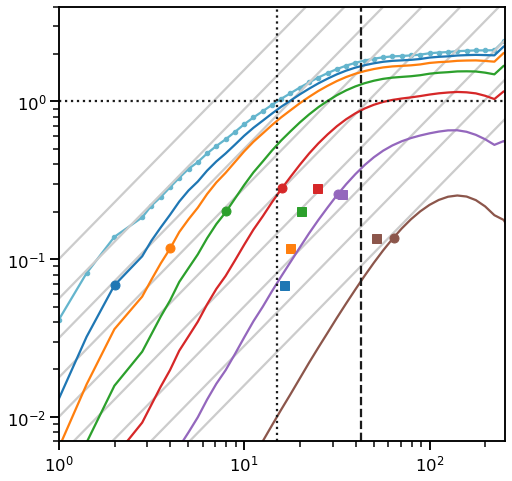

In [55]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
ax.plot(r, Bm, marker=".", color="c")
true_r0 = np.interp(1.0, Bm[:-4], r[:-4])

rgrid = np.logspace(-1.0, 2.5)
for a in np.logspace(-3, -1, 9):
    ax.plot(rgrid, a * rgrid**m, color="0.8")

for width in widths:
    B = np.mean(np.stack(
        [_["Unweighted B(r)"][mask] for _ in sfs_npt_s[width]]
    ), axis=0)
    line = ax.plot(r, B)
    B0 = np.interp(2*width, r, B)
    c = line[0].get_color()
    apparent_r0 = np.mean([_["Apparent r0"] for _ in sfs_npt_s[width]])
    ax.plot(2*width, B0, marker="o", color=c)
    ax.plot(apparent_r0, B0, marker="s", color=c)



ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0, color="k", linestyle="dotted")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log", 
    xlim=[1.0, N], ylim=[7e-3, 4.0]);

In [76]:
def bfac(x):
    """
    Across-the board reduction in B(r) for x = s0 / r0
    
    Where s0 is RMS seeing width and r0 is correlation length
    """
    return np.exp(-x)


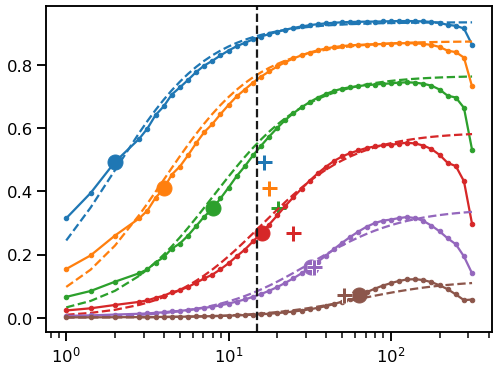

In [91]:
fig, ax = plt.subplots(figsize=(8, 6))
rat_maxes = []
for width in widths:
    B = np.mean(np.stack(
        [_["Unweighted B(r)"][mask] for _ in sfs_npt_s[width]]
    ), axis=0)
    rat = B / Bm
    rat_maxes.append(np.max(rat))
    line = ax.plot(r, rat, marker=".",)
    rat0 = np.interp(2*width, r, rat)
    c = line[0].get_color()
    ax.plot(2*width, rat0, marker="o", ms=15, color=c)
    # Functional fit
    ax.plot(r, seeing_empirical(r, width, true_r0, 0.75), color=c, linestyle="dashed")
    # Plot apparent correlation lengths
    apparent_r0 = np.mean([_["Apparent r0"] for _ in sfs_npt_s[width]])
    ax.plot(apparent_r0, rat0, marker="+", ms=15, mew=5, color="w")
    ax.plot(apparent_r0, rat0, marker="+", ms=15, mew=3, color=c)

ax.axvline(true_r0, color="k", linestyle="dashed")
ax.set(xscale="log", yscale="linear");

Finding a new functional form for `bfunc()`.  Previously I had had $\bigl(1 + 4 (s_0/r_0)^2\bigr)^{-1}$ but now I have $\exp(-s_0 / r_0)$. This works much better for this synthetic case, although it is slightly worse than the first form for Orion.

[Text(0.5, 0, 's0'), Text(0, 0.5, 'max B'), (0.0, 1.0), None]

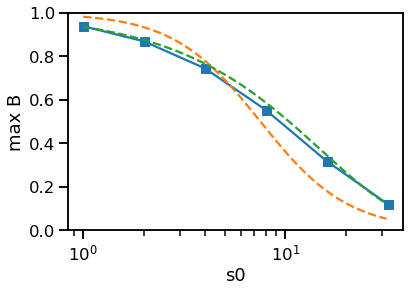

In [75]:
fig, ax = plt.subplots()
ax.plot(widths, rat_maxes, marker="s")
wgrid = np.logspace(0.0, 1.5, 200)
ax.plot(wgrid, bfac(wgrid / true_r0), linestyle="dashed")
ax.plot(wgrid, bfac2(wgrid / true_r0, a=1.), linestyle="dashed")
ax.set(
    xlabel="s0",
    ylabel="max B",
    ylim=[0.0, 1.0],
    xscale="log",
)

## Fake emissivity and velocity cubes

There is not such a rush to do these now, given that the pure velocity maps worked so well.